This notebook performs a blind tip reconstruction for real experimental data

# Original blind tip reconstruction

In [1]:
using Flux
using Plots
using Statistics
using BSON: @save, @load
using Revise, MDToolbox

In [2]:
resolution = 18.75

asd = readasd("8013.asd", readFrameRange = (863, 892), translationSetting = "expansion");

images = []
for i = 1:length(asd.frames)
    push!(images, asd.frames[i].data)
end

In [3]:
function correct_tilt(afms)
    nframe = length(afms)
    height, width = size(afms[1])
    T = eltype(afms[1])
    X = ones(T, nframe*height*width, 3)
    y = zeros(T, nframe*height*width)
    icount = 0
    for iframe = 1:nframe
        for h = 1:height, w = 1:width
            z = afms[iframe][h, w]
            if abs(z) > eps(T)
                icount += 1
                y[icount] = z
                X[icount, 2] = h
                X[icount, 3] = w
            end
        end
    end
    X = X[1:icount, :]
    y = y[1:icount]
    W = inv(X' * X) * X' * y

    afms_clean = deepcopy(afms)
    for iframe = 1:nframe
        for h = 1:height, w = 1:width
            z = afms[iframe][h, w]
            if abs(z) > eps(T)
                afms_clean[iframe][h, w] -= W[1] + W[2]*h + W[3]*w
            end
        end
    end
    return afms_clean
end

correct_tilt (generic function with 1 method)

In [4]:
images = correct_tilt(images);

In [5]:
using Random

function ransac(afms; minimum_ratio_inliers=0.3, cutoff_inliers=3.0*3, num_iter=100000, nsample=1000)
    nframe = length(afms)
    height, width = size(afms[1])
    T = eltype(afms[1])
    X = ones(T, nframe*height*width, 3)
    y = zeros(T, nframe*height*width)
    f = zeros(T, nframe*height*width)
    rmse_min = T(Inf)

    icount = 0
    for iframe = 1:nframe
        for h = 1:height, w = 1:width
            z = afms[iframe][h, w]
            if abs(z) > eps(T)
                icount += 1
                X[icount, 2] = h
                X[icount, 3] = w
                y[icount] = z
                f[icount] = iframe
            end
        end
    end
    X = X[1:icount, :]
    y = y[1:icount]
    f = f[1:icount]
    #W = inv(X' * X) * X' * y

    W_best = zeros(T, 3)
    index_inliers_best = zeros(T, icount)
    for inum = 1:num_iter
        # pick up random samples
        index = randperm(icount)[1:nsample]
        X_sub = X[index, :]
        y_sub = y[index]

        # check inliers ratio
        W = inv(X_sub' * X_sub) * X_sub' * y_sub
        rmse = sqrt.((y .- (W[1] .+ W[2] .* X[:, 1] .+ W[3] .* X[:, 2])).^2)
        index_inliers = rmse .< cutoff_inliers
        ratio_inliers = sum(index_inliers) / icount
        if ratio_inliers < minimum_ratio_inliers
            continue
        end
        
        # construct model using inliers
        X_sub = X[index_inliers, :]
        y_sub = y[index_inliers]
        W = inv(X_sub' * X_sub) * X_sub' * y_sub
        rmse = sqrt.((y_sub .- (W[1] .+ W[2] .* X_sub[:, 1] .+ W[3] .* X_sub[:, 2])).^2)
        if mean(rmse) < rmse_min
            rmse_min = mean(rmse)
            W_best .= W
            index_inliers_best .= index_inliers
            @show rmse_min
        end
    end

    @show W_best
    #afms_clean = deepcopy(afms)
    afms_inliers = deepcopy(afms)
    for i = 1:icount
        iframe = Int(f[i])
        h = Int(X[i, 2])
        w = Int(X[i, 3])
        #afms_clean[iframe][h, w] -= W_best[1] + W_best[2]*T(h) + W_best[3]*T(w)
        if index_inliers_best[i] > 0.5
            afms_inliers[iframe][h, w] = -100.0
        end
    end

    afms_clean = deepcopy(afms)
    for iframe = 1:nframe
        for h = 1:height, w = 1:width
            z = afms[iframe][h, w]
            if abs(z) > eps(T)
                afms_clean[iframe][h, w] -= W_best[1] + W_best[2]*h + W_best[3]*w
            else
                #afms_clean[iframe][h, w] += rmse_min * randn()
            end
       end
    end
    return afms_clean, afms_inliers
end

ransac (generic function with 1 method)

In [6]:
Random.seed!(1234)
images, images_inliers = ransac(images, minimum_ratio_inliers=0.2, cutoff_inliers=10.0*2, nsample=50, num_iter=10000);

rmse_min = 10.332179660852768
rmse_min = 9.96126382111275
rmse_min = 9.022374459220316
rmse_min = 8.815033973035657
rmse_min = 8.640894912362894
rmse_min = 8.591675482002836
rmse_min = 8.45730554020576
rmse_min = 8.444577515540248
rmse_min = 8.391352414132614
rmse_min = 8.37602050342815
rmse_min = 8.334277337438646
rmse_min = 8.322711857953646
rmse_min = 8.287074831012157
W_best = [-5.2812297419804946, -0.026111987856274346, 0.027598206777275647]


In [7]:
gr()

Plots.GRBackend()

┌ Info: Saved animation to 
│   fn = /data/yasu/differentiable_BTR/myosin/original_01.gif
└ @ Plots /opt/julia_depot/packages/Plots/5S9Hg/src/animation.jl:114


Plots.AnimatedGif("/data/yasu/differentiable_BTR/myosin/original_01.gif")
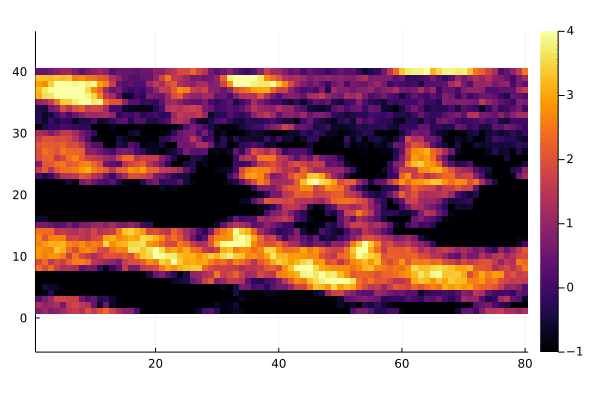

In [8]:
anim = @animate for i = 1:length(images)
    heatmap(images[i] ./ 10.0, clims=(-1, 4), aspect_ratio=:equal)
end

gif(anim, "original_01.gif", fps=5)

## loop over lambda

In [123]:
#T = [0.1, 1.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 100.0]
T = [10.0*1.25^(i) for i = 0:9]
P_array = []
loss_array = []

for t in T
    @info t

    #m_P = zeros(Float64, 11, 23)
    m_P = zeros(Float64, 11, 17)
    itip_estimate!(m_P, images, thresh=t)

    loss = 0.0
    for image in images
        loss += mean((idilation(ierosion(image, m_P), m_P) .- image).^2)
    end
    loss = loss / length(images)
    push!(P_array, m_P)
    push!(loss_array, loss)
end

Processed 30 image
467 refinements 
Processed 30 image
373 refinements 
Processed 30 image
336 refinements 
Processed 30 image
297 refinements 
Processed 30 image
209 refinements 
Processed 30 image
136 refinements 
Processed 30 image
98 refinements 
Processed 30 image
43 refinements 
Processed 30 image
16 refinements 
Processed 30 image
3 refinements 


┌ Info: 10.0
└ @ Main In[123]:7
┌ Info: 12.5
└ @ Main In[123]:7
┌ Info: 15.625
└ @ Main In[123]:7
┌ Info: 19.53125
└ @ Main In[123]:7
┌ Info: 24.4140625
└ @ Main In[123]:7
┌ Info: 30.517578125
└ @ Main In[123]:7
┌ Info: 38.14697265625
└ @ Main In[123]:7
┌ Info: 47.6837158203125
└ @ Main In[123]:7
┌ Info: 59.604644775390625
└ @ Main In[123]:7
┌ Info: 74.50580596923828
└ @ Main In[123]:7


In [124]:
loss_array

10-element Vector{Any}:
   7.015923101091327
  11.368534667342633
  16.501676857033196
  27.579255941353686
  48.90115105229467
  85.00854533126041
 148.0606694715804
 228.75801132571272
 400.12387279754427
 624.4194163571011

In [125]:
gr()

Plots.GRBackend()

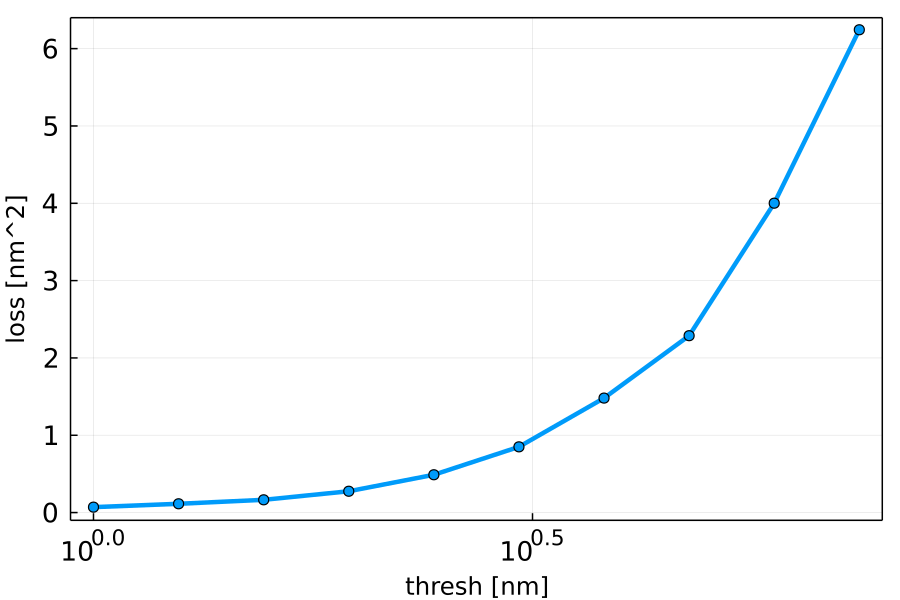

In [167]:
p = plot(T ./ 10.0, loss_array / 100.0, xaxis=:log, framestyle = :box, ylims=(-0.1, 6.4), 
    xlabel="thresh [nm]", ylabel="loss [nm^2]", label=nothing, linewidth=3, markershape=:circle, dpi=150, fmt=:png, 
    xtickfontsize=12, ytickfontsize=12, legendfontsize=12)

In [127]:
savefig(p, "original_02.png")

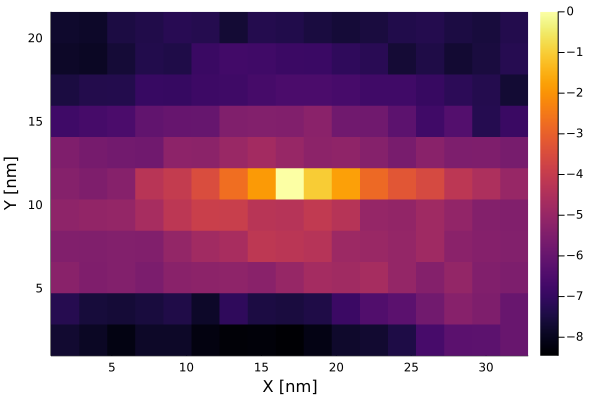

In [128]:
iT = 1
my, mx = size(P_array[1])
heatmap(collect(1:mx) .* resolution ./ 10.0, collect(1:my) .* resolution ./ 10.0, P_array[iT] ./ 10.0, dpi=100)
xlabel!("X [nm]", fontsize=35)
p = ylabel!("Y [nm]", fontsize=35)

In [129]:
savefig(p, "original_03.png")

In [130]:
my, mx = size(P_array[1])
mx

17

In [157]:
using Printf

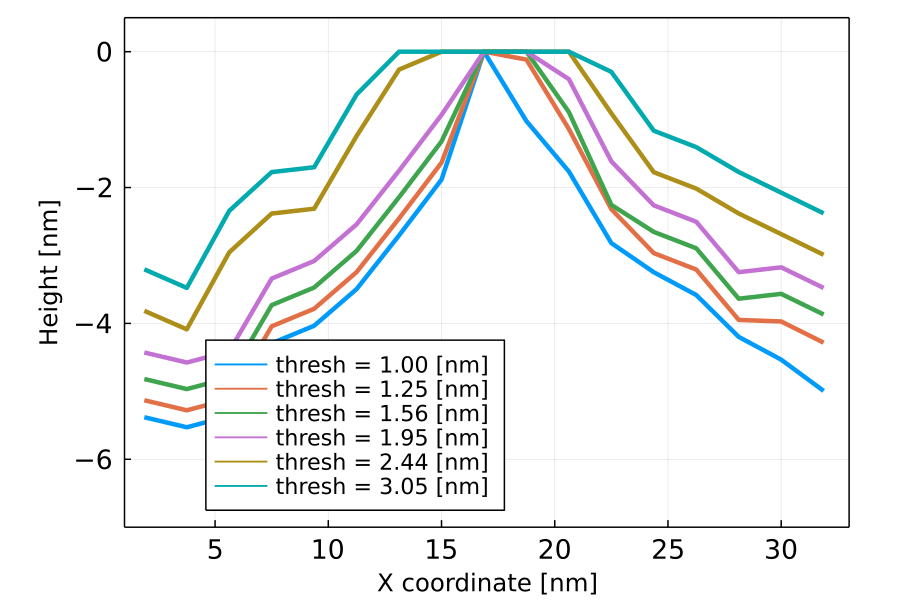

In [175]:
my, mx = size(P_array[1])
islice = 6

iT = 1
str = @sprintf "thresh = %3.2f [nm]" T[iT] ./ 10.0
p = plot(collect(1:mx) .* resolution ./ 10.0, P_array[iT][islice, :] ./ 10.0, linewidth=3, label=str, legend=:bottomleft, framestyle=:box, dpi=150, fmt=:png)

iT = 2
str = @sprintf "thresh = %3.2f [nm]" T[iT] ./ 10.0
p = plot!(collect(1:mx) .* resolution ./ 10.0, P_array[iT][islice, :] ./ 10.0, linewidth=3, label=str, legend=:bottomleft, framestyle=:box, dpi=150, fmt=:png)

iT = 3
str = @sprintf "thresh = %3.2f [nm]" T[iT] ./ 10.0
p = plot!(collect(1:mx) .* resolution ./ 10.0, P_array[iT][islice, :] ./ 10.0, linewidth=3, label=str, legend=:bottomleft, framestyle=:box, dpi=150, fmt=:png)

iT = 4
str = @sprintf "thresh = %3.2f [nm]" T[iT] ./ 10.0
p = plot!(collect(1:mx) .* resolution ./ 10.0, P_array[iT][islice, :] ./ 10.0, linewidth=3, label=str, legend=:bottomleft, framestyle=:box, dpi=150, fmt=:png)

iT = 5
str = @sprintf "thresh = %3.2f [nm]" T[iT] ./ 10.0
p = plot!(collect(1:mx) .* resolution ./ 10.0, P_array[iT][islice, :] ./ 10.0, linewidth=3, label=str, legend=:bottomleft, framestyle=:box, dpi=150, fmt=:png)

iT = 6
str = @sprintf "thresh = %3.2f [nm]" T[iT] ./ 10.0
p = plot!(collect(1:mx) .* resolution ./ 10.0, P_array[iT][islice, :] ./ 10.0, linewidth=3, label=str, framestyle=:box, dpi=150, fmt=:png, 
          legend=:bottom, aspect_ratio=3, xtickfontsize=12, ytickfontsize=12, legendfontsize=10)

ylims!((-7, 0.5))
xlims!((1, 33))
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Height [nm]", fontsize=35)

In [162]:
savefig(p, "original_04.png")

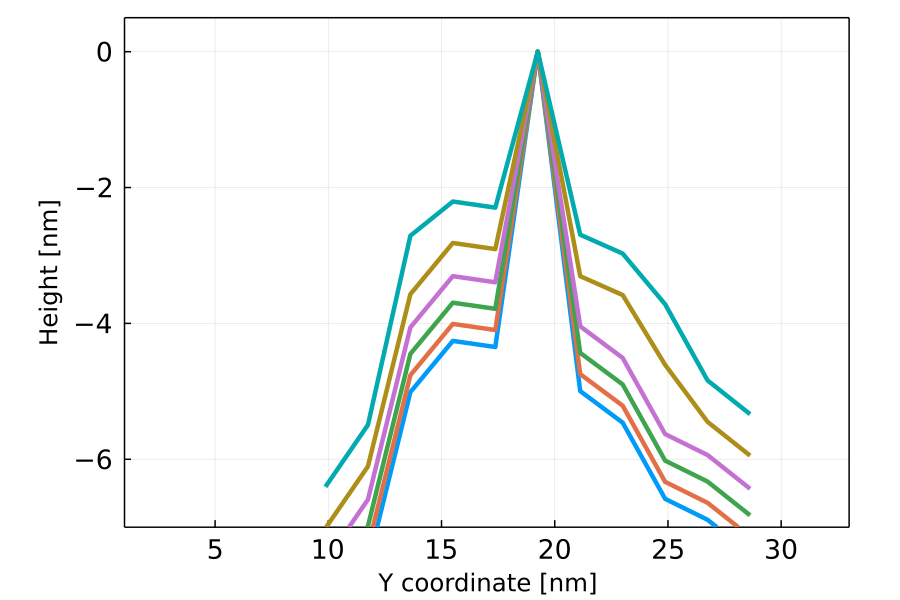

In [163]:
my, mx = size(P_array[1])
islice = 9

iT = 1
p = plot(collect(1:my) .* resolution ./ 10.0 .+ 8, P_array[iT][:, islice] ./ 10.0, linewidth=3, label="thresh=$(T[iT]/10)", legend=:bottomleft, framestyle=:box, dpi=150, fmt=:png)

iT = 2
p = plot!(collect(1:my) .* resolution ./ 10.0 .+ 8, P_array[iT][:, islice] ./ 10.0, linewidth=3, label="thresh=$(T[iT]/10)", legend=:bottomleft, framestyle=:box, dpi=150, fmt=:png)

iT = 3
p = plot!(collect(1:my) .* resolution ./ 10.0 .+ 8, P_array[iT][:, islice] ./ 10.0, linewidth=3, label="thresh=$(T[iT]/10)", legend=:bottomleft, framestyle=:box, dpi=150, fmt=:png)

iT = 4
p = plot!(collect(1:my) .* resolution ./ 10.0 .+ 8, P_array[iT][:, islice] ./ 10.0, linewidth=3, label="thresh=$(T[iT]/10)", legend=:bottomleft, framestyle=:box, dpi=150, fmt=:png)

iT = 5
p = plot!(collect(1:my) .* resolution ./ 10.0 .+ 8, P_array[iT][:, islice] ./ 10.0, linewidth=3, label="thresh=$(T[iT]/10)", legend=:bottomleft, framestyle=:box, dpi=150, fmt=:png)

iT = 6
p = plot!(collect(1:my) .* resolution ./ 10.0 .+ 8, P_array[iT][:, islice] ./ 10.0, linewidth=3, label="thresh=$(T[iT]/10)", framestyle=:box, dpi=150, fmt=:png,  
          legend=nothing, aspect_ratio=3, xtickfontsize=12, ytickfontsize=12, legendfontsize=10)

ylims!((-7, 0.5))
xlims!((1, 33))
#xlims!((1, 21))
xlabel!("Y coordinate [nm]", fontsize=35)
ylabel!("Height [nm]", fontsize=35)

In [164]:
savefig(p, "original_05.png")

In [ ]:
pyplot()

In [ ]:
tip_tmp = deepcopy(P_array[4])
tip_tmp[tip_tmp .< -150.0] .= NaN

my, mx = size(P_array[1])
plot(collect(1:mx) .* resolution ./ 10.0, collect(1:my) .* resolution ./ 10.0, tip_tmp ./ 10.0, st=:surface, dpi=150, 
     xtickfontsize=12, ytickfontsize=12, ztickfontsize=12, legendfontsize=12, colorbar_tickfontsize=12)
xlabel!("X [nm]", fontsize=35)
p = ylabel!("Y [nm]", fontsize=35)
#zlabel!("Z [nm]", fontsize=35)
#zlims!((-8, 0.5))
#zlabel!("Tip height [nm]", fontsize=35)

In [ ]:
savefig(p, "original_06.png")

In [ ]:
gr()

In [ ]:
iframe = 27
ny, nx = size(images[iframe])
p = heatmap(collect(1:nx) .* resolution / 10.0, collect(1:ny) .* resolution / 10.0, images[iframe] ./ 10.0, dpi=150, fmt=:png, clims=(-1, 4), aspect_ratio=:equal)
xlims!(0, nx*resolution/10.0)
ylims!(0, ny*resolution/10.0)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)

In [ ]:
savefig(p, "original_07.png")

In [ ]:
iframe = 27
ny, nx = size(images[iframe])
p = heatmap(collect(1:nx) .* resolution / 10.0, collect(1:ny) .* resolution / 10.0, ierosion(images[iframe], P_array[4]) ./ 10.0, dpi=150, fmt=:png, clims=(-1, 4), aspect_ratio=:equal)
xlims!(0, nx*resolution/10.0)
ylims!(0, ny*resolution/10.0)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)

In [ ]:
savefig(p, "original_08.png")

In [ ]:
img = []

ny, nx = size(images[1])
anim = @animate for i = 1:length(images)
    push!(img, images[i])
    heatmap(collect(1:nx) .* resolution / 10.0, collect(1:ny) .* resolution / 10.0, images[i] / 10.0, xlabel="X coordinate [nm]", ylabel="Y coordinate [nm]", dpi=150, fmt=:png, clims=(-1, 4), aspect_ratio=:equal)
    xlims!(0, nx*resolution/10.0)
    ylims!(0, ny*resolution/10.0)
end

@save "original_09.bson" img resolution
gif(anim, "original_09.gif", fps=5)

┌ Info: Saved animation to 
│   fn = /data/yasu/differentiable_BTR/myosin/original_10.gif
└ @ Plots /opt/julia_depot/packages/Plots/5S9Hg/src/animation.jl:114


Plots.AnimatedGif("/data/yasu/differentiable_BTR/myosin/original_10.gif")
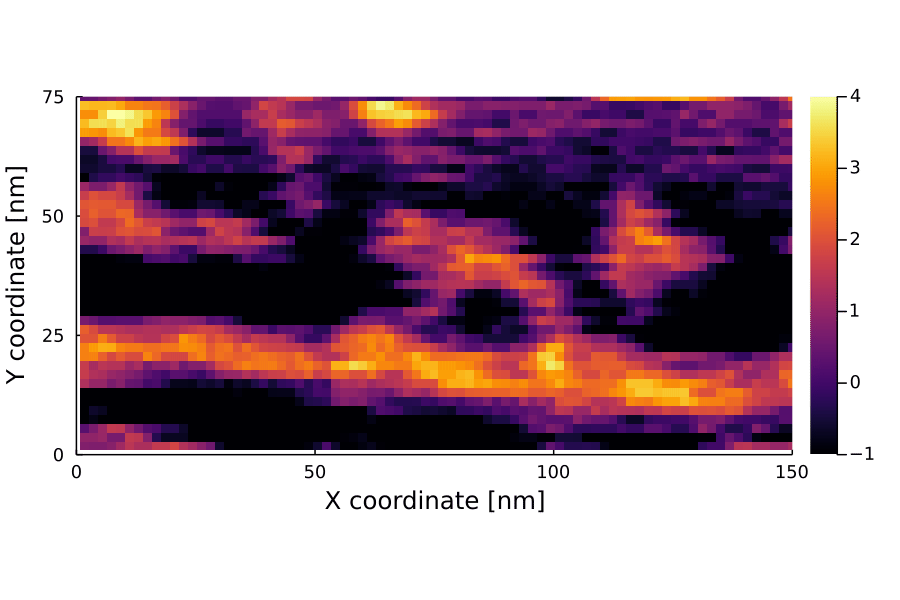

In [172]:
img = []
iT = 4

ny, nx = size(images[1])
anim = @animate for i = 1:length(images)
    push!(img, ierosion(images[i], P_array[5]))
    heatmap(collect(1:nx) .* resolution / 10.0, collect(1:ny) .* resolution / 10.0, ierosion(images[i], P_array[iT]) / 10.0, xlabel="X coordinate [nm]", ylabel="Y coordinate [nm]", dpi=150, fmt=:png, clims=(-1, 4), aspect_ratio=:equal)
    xlims!(0, nx*resolution/10.0)
    ylims!(0, ny*resolution/10.0)
end

@save "original_10.bson" img resolution
gif(anim, "original_10.gif", fps=5)

# Comparison with structural models

In [ ]:
#@load "/data/yasu/myosin/analyse/for_blindtip.bson" models qs params
#@load "/data/yasu/myosin/analyse/for_blindtip.bson" models models_state qs params
@load "for_blindtip.bson" models qs params

In [ ]:
qs

In [ ]:
width = 20
height = 40
resolution = 18.75
params = [AfmizeConfig(10.0 * (pi / 180),
        r, 
        MDToolbox.Point2D(-height * resolution, -width * resolution), 
        MDToolbox.Point2D(height * resolution, width * resolution), 
        MDToolbox.Point2D(resolution, resolution), 
        MDToolbox.defaultParameters())
        for r in [30]];

In [ ]:
heatmap(idilation(surfing(models[1, :], params[1]), MDToolbox.translate_tip_mean(P_array[6])))

In [ ]:
function obb(image::Matrix{T}, surf::Matrix{T}) where {T}
    height, width = size(image)

    h_nonzero = 1
    for h = 1:height
        if maximum(image[h, :]) > eps(T)
            h_nonzero = h
            break
        end
    end
    h_min = max(1, h_nonzero)
    
    h_nonzero = height
    for h = height:-1:1
        if maximum(image[h, :]) > eps(T)
            h_nonzero = h
            break
        end
    end
    h_max = min(height, h_nonzero)

    w_nonzero = 1
    for w = 1:width
        if maximum(image[:, w]) > eps(T)
            w_nonzero = w
            break
        end
    end
    w_min = max(1, w_nonzero)
   
    w_nonzero = width
    for w = width:-1:1
        if maximum(image[:, w]) > eps(T)
            w_nonzero = w
            break
        end
    end
    w_max = min(width, w_nonzero)
    
    return image[h_min:h_max, w_min:w_max], surf[h_min:h_max, w_min:w_max]
end

In [ ]:
function obb_position(image::Matrix{T}) where {T}
    height, width = size(image)

    h_nonzero = 1
    for h = 1:height
        if maximum(image[h, :]) > eps(T)
            h_nonzero = h
            break
        end
    end
    h_min = max(1, h_nonzero)
    
    h_nonzero = height
    for h = height:-1:1
        if maximum(image[h, :]) > eps(T)
            h_nonzero = h
            break
        end
    end
    h_max = min(height, h_nonzero)

    w_nonzero = 1
    for w = 1:width
        if maximum(image[:, w]) > eps(T)
            w_nonzero = w
            break
        end
    end
    w_min = max(1, w_nonzero)
   
    w_nonzero = width
    for w = width:-1:1
        if maximum(image[:, w]) > eps(T)
            w_nonzero = w
            break
        end
    end
    w_max = min(width, w_nonzero)
    
    return h_min, w_min
end

In [ ]:
#@everywhere pixel_rmsd(image1, image2; sigma=8.5) = exp(- sum((image1 .- image2).^2) ./ (2.0 * sigma^2))
pixel_rmsd(image1, image2; sigma=8.5) = - sum((image1 .- image2).^2) ./ 2.0 * sigma^2

function masked_rmsd(image1, image2; sigma=8.5)
    id = abs.(image2) .> eps(Float64)
    npixel = sum(id)
    r = (1.0 ./ Float64(npixel)) .* sum((image1[id] .- image2[id]).^2) ./ 2.0 * sigma^2
    return - r
end

function best_rmsd(image1, image2)
    s2_y = sum((image1 .- mean(image1)).^2)
    s2_x = sum((image2 .- mean(image2)).^2)
    s_xy = sum((image2 .- mean(image2)) .* (image1 .- mean(image1)))
    #r = s2_y * (1.0 - (s_xy^2 / (s2_x * s2_y)))
    r = (1.0 - (s_xy^2 / (s2_x * s2_y)))
    return - r
end

#@everywhere cosine_similarity(image1, image2; sigma=1.0) = exp(- sum((image1./std(image1) .- image2./std(image1)).^2) ./ (2.0 * sigma^2))
cosine_similarity(image1, image2; sigma=1.0) = - sum((image1./std(image1) .- image2./std(image1)).^2) ./ (2.0 * sigma^2)

crosscor(image1, image2) = mean((image1 .- mean(image1)) .* (image2 .- mean(image2))) / (std(image1) * std(image2))

function cossio(observed, calculated)
    T = eltype(observed)
    npix = T(size(observed, 1)*size(observed, 2))
    C_o  = sum(observed)
    C_c  = sum(calculated)
    C_cc = sum(calculated.^2)
    C_oo = sum(observed.^2)
    C_oc = sum(observed.*calculated)
    log01 = npix .* (C_cc .* C_oo .- C_oc.^2) .+ T(2) .* C_o .* C_oc .* C_c .- C_cc .* C_o.^2 .- C_oo .* C_c.^2
    log02 = (npix .- T(2)) .* (npix .* C_cc .- C_c.^2)
    logprob = T(0.5) .* log(pi) .+ (T(1.0) .- npix) .* log(T(2.0) .* pi .* exp(T(1.0))) .+ T(0.5) .* (T(3.0) .- npix) .* log.(log01) .+ (T(0.5) .* npix .- T(2.0)) .* log(log02)
    return logprob
end

In [ ]:
function similarity_over_trans(image::Matrix{T}, kernel::Matrix{T}; func=cossio) where {T}
    HEIGHT, WIDTH = size(image)
    height, width = size(kernel)

    #@show HEIGHT, WIDTH
    #@show height, width
    h_max = HEIGHT - height + 1
    w_max = WIDTH - width + 1
    C = zeros(T, (h_max, w_max))
    
    #kernel_diff = kernel .- mean(kernel)
    #kernel_std = std(kernel)
    Threads.@threads for h = 1:h_max
        for w = 1:w_max
            image2 = view(image, h:(h+height-1), w:(w+width-1))
            C[h, w] = func(image2, kernel)
        end
    end
    
    return C
end

In [ ]:
function compute_likelihood_over_rotrans(afm::Matrix{Float64}, models::TrjArray, qs::Matrix{Float64}, zs::Vector{Float64}, params, tip; func=cossio)
    L = zeros(Float64, models.nframe)
    L2 = zeros(Float64, models.nframe * size(qs, 1) * length(zs), 2)
    best_likelihood = - Inf64
    best_imodel = 0
    best_model = deepcopy(models[1, :])
    best_iq = 0
    best_q = zeros(Float64, 4)
    best_z = 0.0
    best_h = 0
    best_w = 0
    best_afm = zeros(Float64, size(afm))
    best_surf = zeros(Float64, size(afm))
    best_param = params[1]
    best_alpha = 0.0
    best_beta = 0.0

    count = 0
    for imodel in 1:models.nframe
        model = models[imodel, :]
        for iq in 1:size(qs, 1)
            q = qs[iq, :]
            model_rotated = MDToolbox.rotate(model, q)
            model_rotated.xyz[1:1, 3:3:end] .-= minimum(model_rotated[:, 3655:end].xyz[1, 3:3:end])
            for iparam in 1:length(params)
                param = params[iparam]
                #calculated = afmize(model_rotated, param, removeBottom=true
                surf = surfing(model_rotated, param)
                surf .-= minimum(model_rotated[:, 3655:end].xyz[1, 3:3:end])
                calculated = idilation(surf, tip)
                h_min, w_min = obb_position(calculated)
                calculated, surf = obb(calculated, surf)
                for iz = 1:length(zs)
                    z = zs[iz]
                    C = similarity_over_trans(afm, calculated .+ z, func=func)
                    L[imodel] += sum(C)
                    count += 1
                    L2[count, 1] = mean(model_rotated[:, 1:3654].xyz[1, 3:3:end]) + z
                    L2[count, 2] = sum(C)
                    if best_likelihood < maximum(C)
                        best_likelihood = maximum(C)
                        best_imodel = imodel
                        best_model = deepcopy(model_rotated)
                        best_iq = iq
                        best_q .= q
                        best_h = argmax(C)[1]
                        best_w = argmax(C)[2]
                        best_z = z
                        Y = afm[best_h:(best_h+size(calculated,1)-1), best_w:(best_w+size(calculated,2)-1)]
                        X = calculated
                        best_beta = sum((X .- mean(X)) .* (Y .- mean(Y))) / sum((X .- mean(X)) .* (X .- mean(X)))
                        best_alpha = mean(Y) - best_beta * mean(X)
                        best_afm .= best_alpha
                        best_afm[best_h:(best_h+size(calculated,1)-1), best_w:(best_w+size(calculated,2)-1)] .= best_beta .* calculated .+ best_alpha
                        best_surf .= best_alpha
                        best_surf[best_h:(best_h+size(calculated,1)-1), best_w:(best_w+size(calculated,2)-1)] .= best_beta .* surf .+ best_alpha
                        best_h = best_h - h_min + 1
                        best_w = best_w - w_min + 1
                        best_param = params[iparam]
                    end
                end
            end
        end
        L[imodel] = L[imodel] / (size(qs, 1) * length(params) * length(afm))
    end
    best = (likelihood=best_likelihood, imodel=best_imodel, model=best_model, iq=best_iq, q=best_q, z=best_z, h=best_h, w=best_w, afm=best_afm, surf=best_surf, param=best_param, alpha=best_alpha, beta=best_beta)

    return L, L2, best
end

In [ ]:
ENV["COLUMNS"] = 150; #display width for MDToolbox

In [ ]:
using Printf

#mm = mdload("flexible_fitting/down_down_01.pdb")
#mm = vcat(mm, mdload("flexible_fitting/down_up_01.pdb"));
#mm = vcat(mm, mdload("flexible_fitting/down_up_02.pdb"));
#mm = vcat(mm, mdload("flexible_fitting/down_up_03.pdb"));

mm = mdload("down_down/01.pdb")
for i = 2:10
    filename = @sprintf "down_down/%02d.pdb" i
    mm = vcat(mm, mdload(filename))
end

c_ref = mm[1, :]
index_myosin = 1:4056
index_actin = 4057:15681
orient!(c_ref, index=index_actin)

MDToolbox.superimpose!(c_ref, mm, index=index_actin)

mm = mm[:, [1:939; 1141:2967; 3169:end]]

mm.atomname .= mm.resname;
mm

In [ ]:
function rot2q(R)
    r11 = R[1, 1]
    r12 = R[1, 2]
    r13 = R[1, 3]
    r21 = R[2, 1]
    r22 = R[2, 2]
    r23 = R[2, 3]
    r31 = R[3, 1]
    r32 = R[3, 2]
    r33 = R[3, 3]
    q0 = ( r11 + r22 + r33 + 1.0) / 4.0
    q1 = ( r11 - r22 - r33 + 1.0) / 4.0
    q2 = (-r11 + r22 - r33 + 1.0) / 4.0
    q3 = (-r11 - r22 + r33 + 1.0) / 4.0
    if (q0 < 0.0)
        q0 = 0.0
    end
    if (q1 < 0.0)
        q1 = 0.0
    end
    if (q2 < 0.0)
        q2 = 0.0
    end
    if (q3 < 0.0)
        q3 = 0.0
    end
    q0 = sqrt(q0)
    q1 = sqrt(q1)
    q2 = sqrt(q2)
    q3 = sqrt(q3)
    if (q0 >= q1) & (q0 >= q2) & (q0 >= q3)
        q0 *= +1.0
        q1 *= sign(r32 - r23)
        q2 *= sign(r13 - r31)
        q3 *= sign(r21 - r12)
    elseif (q1 >= q0) & (q1 >= q2) & (q1 >= q3)
        q0 *= sign(r32 - r23)
        q1 *= +1.0
        q2 *= sign(r21 + r12)
        q3 *= sign(r13 + r31)
    elseif (q2 >= q0) & (q2 >= q1) & (q2 >= q3)
        q0 *= sign(r13 - r31)
        q1 *= sign(r21 + r12)
        q2 *= +1.0
        q3 *= sign(r32 + r23)
    elseif(q3 >= q0) & (q3 >= q1) & (q3 >= q2)
        q0 *= sign(r21 - r12);
        q1 *= sign(r31 + r13);
        q2 *= sign(r32 + r23);
        q3 *= +1.0;
    else
        println("coding error")
    end
    r = sqrt(q0^2 + q1^2 + q2^2 + q3^2)
    q0 /= r
    q1 /= r
    q2 /= r
    q3 /= r
    return [q1, q2, q3, q0]
end

In [ ]:
qs = zeros(Float64, (length(-60:3:60)*length(40:3:220), 4))
icount = 0
for z = -60:3:60
    theta_z = (z/360.0) * (2.0*pi)
    for x = 40:3:220
        theta_x = (x/360.0) * (2.0*pi)
        R_x = [1.0 0.0 0.0; 0.0 cos(theta_x) -sin(theta_x); 0.0 sin(theta_x) cos(theta_x)]
        #R_y = [cos(theta_y) 0.0 sin(theta_y); 0.0 1.0 0.0; -sin(theta_y) 0.0 cos(theta_y)]
        R_z = [cos(theta_z) -sin(theta_z) 0.0; sin(theta_z) cos(theta_z) 0.0; 0.0 0.0 1.0]
        R = R_x * R_z
        icount += 1
        qs[icount, :] .= rot2q(R)
    end
end

In [ ]:
# crosscor
iframe = 27
#mm = models_state[1]
#mm = vcat(mm, models_state[2])
#mm = vcat(mm, models_state[3])
#mm = vcat(mm, models_state[4])

L_all, L2_all, best_all = compute_likelihood_over_rotrans(images[iframe], mm, qs[1:1:end, :], [0.0], params, 2.0 .* P_array[4], func=crosscor)

bs = []
Ls = []
L2s = []

for i = 1:mm.nframe
    L, L2, best = compute_likelihood_over_rotrans(images[iframe], mm[i], qs[1:1:end, :], [0.0], params, 2.0 .* P_array[4], func=crosscor)
    push!(bs, best)
    push!(Ls, L)
    push!(L2s, L2)
end

In [ ]:
best_all.imodel

In [ ]:
s = 0.0
for i = 1:mm.nframe
    @show i bs[i].likelihood
    s += bs[i].likelihood
end
s

In [ ]:
ny, nx = size(images[1])
p = heatmap(collect(1:nx) .* resolution / 10.0, collect(1:ny) .* resolution / 10.0, images[iframe] ./ 10.0, dpi=150, fmt=:png, clims=(-1, 4), aspect_ratio=:equal)
xlims!(0, nx*resolution/10.0)
ylims!(0, ny*resolution/10.0)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)

In [ ]:
ny, nx = size(images[iframe])
p = heatmap(collect(1:nx) .* resolution / 10.0, collect(1:ny) .* resolution / 10.0, best_all.afm ./ 10.0, dpi=150, fmt=:png, clims=(-1, 4), aspect_ratio=:equal)
xlims!(0, nx*resolution/10.0)
ylims!(0, ny*resolution/10.0)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)

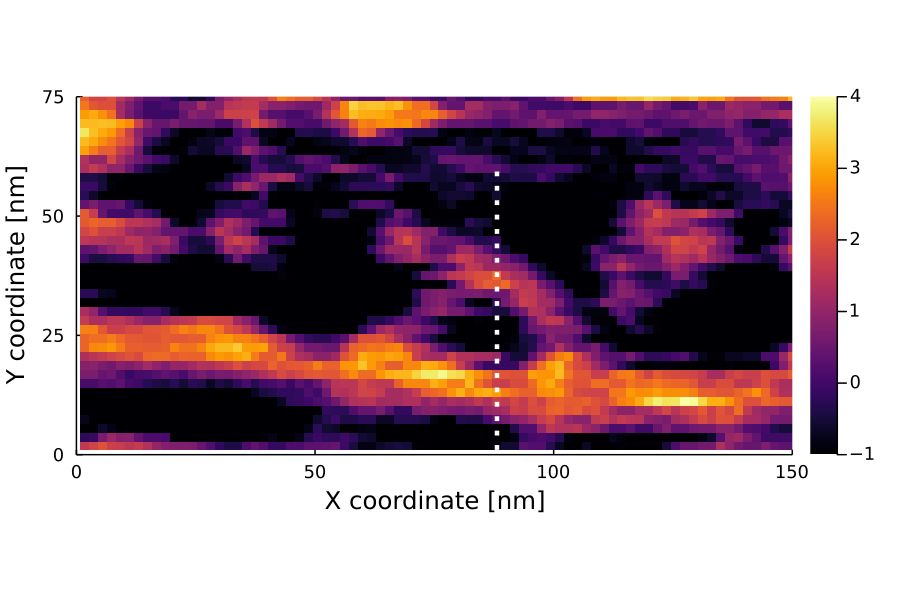

In [169]:
ny, nx = size(images[iframe])
iT = 4
p = heatmap(collect(1:nx) .* resolution / 10.0, collect(1:ny) .* resolution / 10.0, ierosion(images[iframe], P_array[iT]) ./ 10.0, dpi=150, fmt=:png, clims=(-1, 4), aspect_ratio=:equal)
xlims!(0, nx*resolution/10.0)
ylims!(0, ny*resolution/10.0)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)

i = 47
plot!(fill(1.0, 60) .* i .* resolution ./ 10.0, collect(1:60), color=:white, label=nothing, linewidth=3.0, linestyle=:dot)

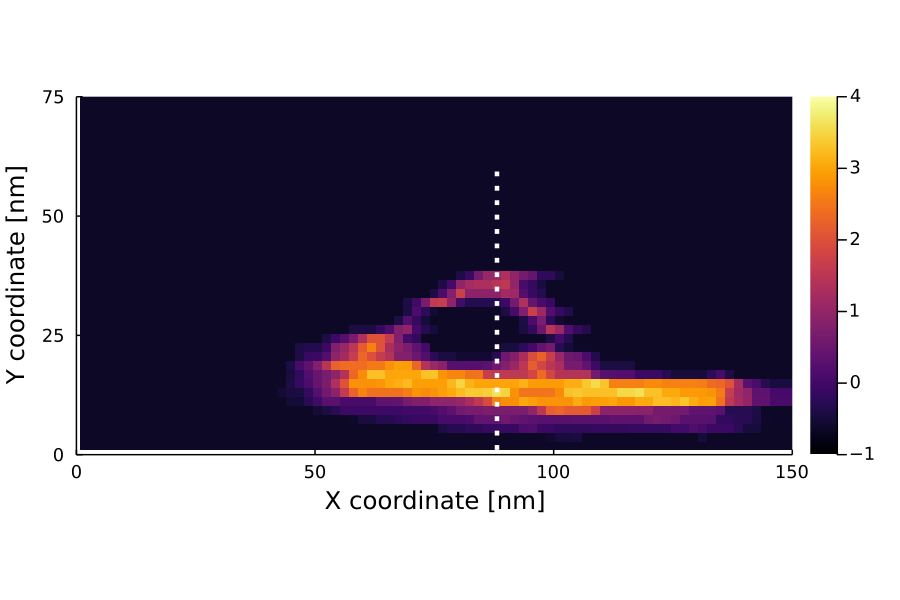

In [170]:
ny, nx = size(images[iframe])
p = heatmap(collect(1:nx) .* resolution / 10.0, collect(1:ny) .* resolution / 10.0, ierosion(best_all.afm, P_array[5]) ./ 10.0, dpi=150, fmt=:png, clims=(-1, 4), aspect_ratio=:equal)
xlims!(0, nx*resolution/10.0)
ylims!(0, ny*resolution/10.0)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)

i = 47
plot!(fill(1.0, 60) .* i .* resolution ./ 10.0, collect(1:60), color=:white, label=nothing, linewidth=3.0, linestyle=:dot)

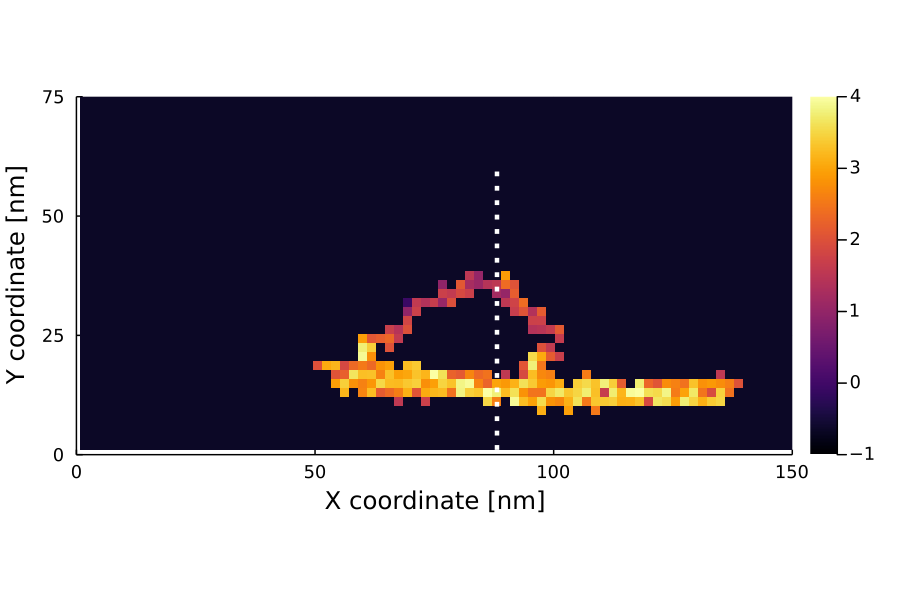

In [171]:
ny, nx = size(images[iframe])
p = heatmap(collect(1:nx) .* resolution / 10.0, collect(1:ny) .* resolution / 10.0, best_all.surf ./ 10.0, dpi=150, fmt=:png, clims=(-1, 4), aspect_ratio=:equal)
xlims!(0, nx*resolution/10.0)
ylims!(0, ny*resolution/10.0)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)

i = 47
plot!(fill(1.0, 60) .* i .* resolution ./ 10.0, collect(1:60), color=:white, label=nothing, linewidth=3.0, linestyle=:dot)

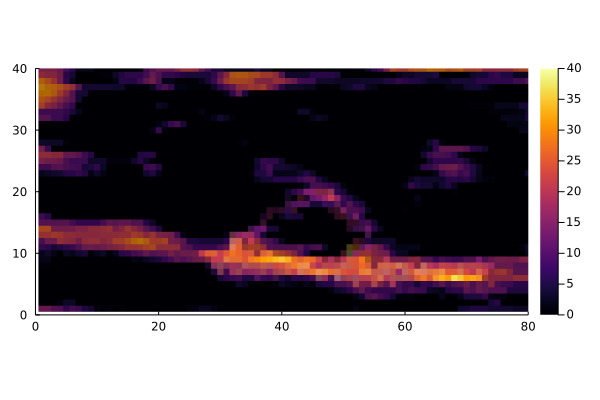

┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /opt/julia_depot/packages/Plots/5S9Hg/src/backends/gr.jl:513


In [153]:
#heatmap(ierosion(best.afm, translate_tip_mean(P_over_lambdas[8])), clims=(0, 100))
heatmap(ierosion(images[iframe], P_array[5]), clims=(0, 40), aspect_ratio=:equal)
heatmap!(best_all.surf, alpha=0.3, clims=(0, 40), aspect_ratio=:equal)
xlims!(0, nx)
ylims!(0, ny)

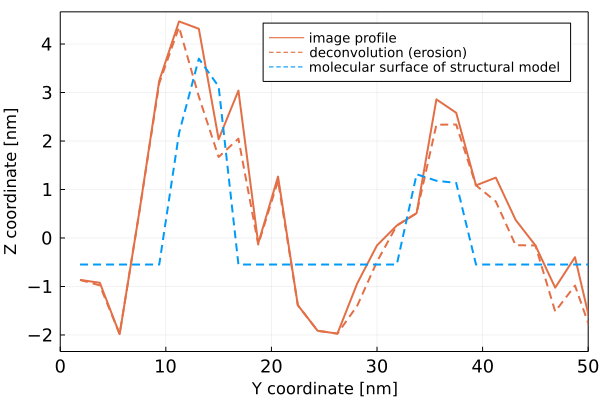

In [173]:
i = 47
iT = 4

plot(collect(1:ny) .* resolution ./ 10.0, images[iframe][1:end, i] ./ 10.0, framestyle=:box, xlabel="Y coordinate [nm]", ylabel="Z coordinate [nm]", label="image profile", color=2, linewidth=2)
plot!(collect(1:ny) .* resolution ./ 10.0, ierosion(images[iframe] ./ 10.0, P_array[iT])[1:end, i], framestyle=:box, label="deconvolution (erosion)", color=2, linewidth=2, linestyle=:dash)

#plot!(bs[imodel].afm[1:end, i], framestyle=:box, xlabel="Y [Angstrom]", ylabel="Z [Angstrom]", label="dilation of structural model", color=:red, linestyle=:solid)
#plot!(ierosion(bs[imodel].afm, translate_tip_mean(P_over_lambdas[i_lambda]))[1:end, i], framestyle=:box, xlabel="Y [Angstrom]", ylabel="Z [Angstrom]", label="erosion of dilation", color=:red, linestyle=:dash)

imodel = 7
plot!(collect(1:ny) .* resolution ./ 10.0, bs[imodel].surf[1:end, i] ./ 10.0, framestyle=:box, label="molecular surface of structural model", color=1, linestyle=:dash, linewidth=2, legend=:topright,
      xtickfontsize=12, ytickfontsize=12, legendfontsize=9, colorbar_tickfontsize=10, markersize=12, markerstrokewidth=1)
#imodel = 2
#plot!(bs[imodel].surf[1:end, i], framestyle=:box, xlabel="Y [Angstrom]", ylabel="Z [Angstrom]", label=nothing, legend=:bottomright, color=1, linestyle=:dash, linewidth=2)
#imodel = 3
#plot!(bs[imodel].surf[1:end, i], framestyle=:box, xlabel="Y [Angstrom]", ylabel="Z [Angstrom]", label=nothing, legend=:bottomright, color=1, linestyle=:dash, linewidth=2)
#imodel = 4
#plot!(bs[imodel].surf[1:end, i], framestyle=:box, xlabel="Y [Angstrom]", ylabel="Z [Angstrom]", label=nothing, legend=:topright, color=1, linestyle=:dash, linewidth=2)

xlims!(0, 50)

# Save results

In [155]:
max_corr = []
for i = 1:mm.nframe
    push!(max_corr, bs[i].likelihood)
end

using BSON: @save, @load

@save "blindtip_myosin_original_863-892_max_corr.bson" max_corr

In [156]:
@save "blindtip_myosin_original_863-892.bson" images T P_array L_all L2_all best_all bs Ls L2s